# Classificação de Notas de Redações do ENEM

Este Notebook detalha a realização da classificação automática de notas de redações do ENEM utilizando o dataset de redações do ENEM e a biblioteca AIBoxLab. Seguiremos os seguintes passos:

1.   Carregar o dataset de redações do ENEM e converter para o formato da AIBoxLab.
2.   Analisar o dataset através de gráficos para entender as distribuições.
3.   Extrair características (features) utilizando o AIBoxLab.
4.   Salvar um conjunto de treino e teste.
5.   Realizar a hiperparametrização de dois modelos (RandomForest e LogisticRegression) e salvar os melhores modelos para posterior análise.



## Setup

In [ ]:
!pip install aibox-nlp[BR]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.4/427.4 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a w

In [ ]:
!pip install imbalanced-learn

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from aibox.nlp.factory.experiment import SimpleExperimentBuilder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from aibox.nlp.data.datasets import DatasetEssayBR
from sklearn.preprocessing import StandardScaler
from aibox.nlp.data.datasets import DatasetDF
from aibox.nlp.factory import get_extractor
from scipy.stats import randint, uniform
from imblearn.over_sampling import SMOTE
from aibox.nlp import serialization
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import glob
import json
import re



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Preparação do Dataset

### Carregar o Dataset

In [ ]:
ds = DatasetEssayBR(extended=True, target_competence='score')
df = ds.to_frame()

print(f"Número total de redações: {len(df)}")

nlpbox: download datasets/essay-br-extended.v1: 100%|██████████| 12.1M/12.1M [00:00<00:00, 21.2MB/s]


Número total de redações: 6564


In [ ]:
df.head()

,text,target,C1,C2,C3,C4,C5,score,prompt
0,Comenta-se que o ex presidente Lula ex-preside...,0,0,0,0,0,0,0,"No início deste mês de novembro, o Supremo Tri..."
1,"Amazonas, sem ela ele os dias do brasil Brasil...",0,0,0,0,0,0,0,"No final de agosto passado, as queimadas na fl..."
2,Eu acredito que os dois são muito importantes ...,0,0,0,0,0,0,0,"De modo geral, não é segredo para ninguém que ..."
3,Assunto que repercute de forma constante nos a...,0,0,0,0,0,0,0,"No início deste mês de novembro, o Supremo Tri..."
4,O supremo tribunal federal Supremo Tribunal Fe...,0,0,0,0,0,0,0,"Ao longo dos últimos dez anos, o papel do STF ..."


### Converter para o Formato da AIBoxLab

In [ ]:
# Remover duplicados com base no texto
df = df.drop_duplicates(subset='text')

# Considerando que queremos prever a 'target'
# Vamos também remover redações sem nota
df = df.dropna(subset=['target', 'text'])

# Criar o dataset da AIBoxLab
dataset = DatasetDF(df, text_column='text', target_column='target')


## 2. Analisar o Dataset Através de Gráficos

### Distribuição de Redações por Nota Final

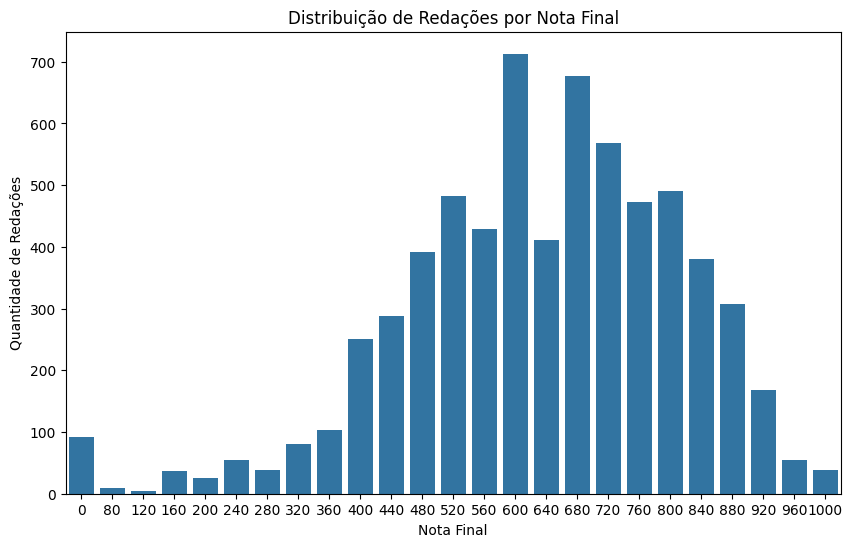

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='target', data=df)
plt.title('Distribuição de Redações por Nota Final')
plt.xlabel('Nota Final')
plt.ylabel('Quantidade de Redações')
plt.show()


### Palavras Mais Recorrentes em Redações com Nota < 5 e > 8

In [ ]:
stop_words = set(stopwords.words('portuguese'))

def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    all_words = [word for word in all_words if word not in stop_words and len(word)>3]
    counter = Counter(all_words)
    return counter.most_common(n)


#### Redações com Nota < 5

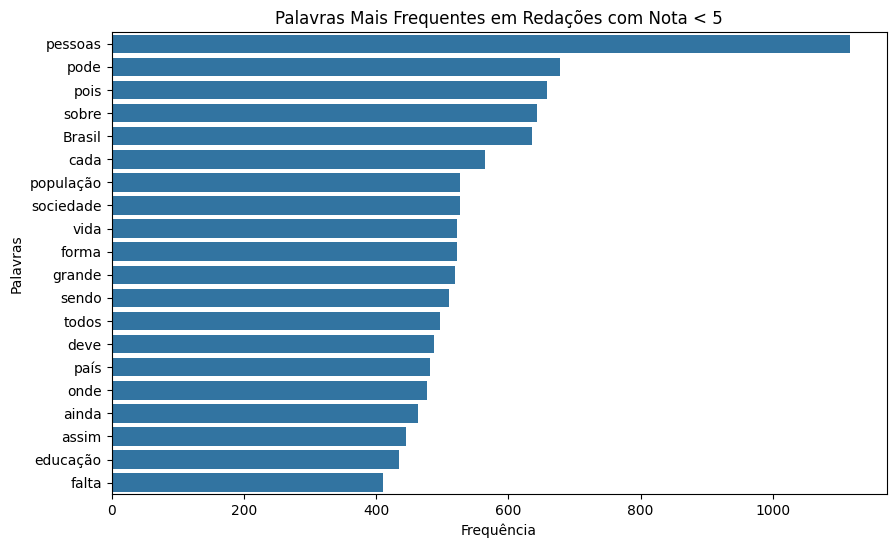

In [ ]:
texts_below_5 = df[df['target'] < 500]['text']
top_words_below_5 = get_top_words(texts_below_5)

# Plotar
words, counts = zip(*top_words_below_5)
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Palavras Mais Frequentes em Redações com Nota < 5')
plt.xlabel('Frequência')
plt.ylabel('Palavras')
plt.show()


#### Redações com Nota > 8

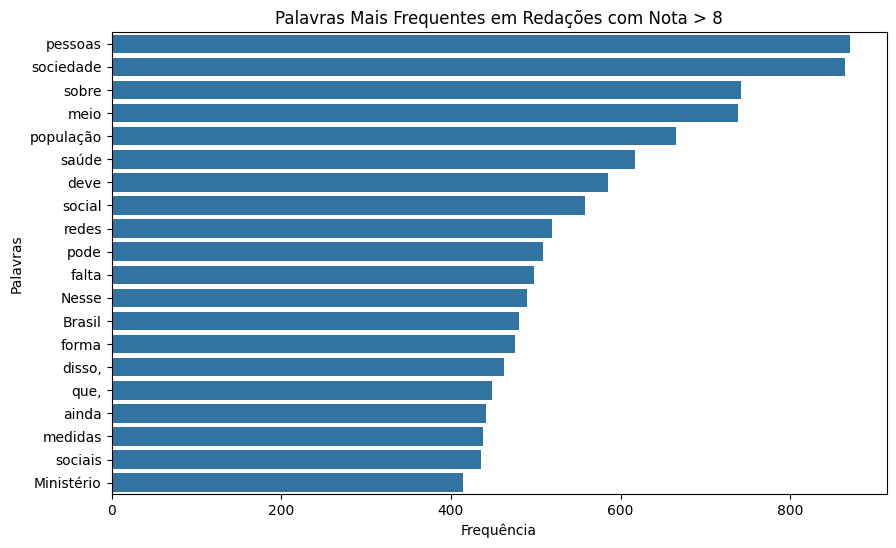

In [ ]:
texts_above_8 = df[df['target'] > 800]['text']
top_words_above_8 = get_top_words(texts_above_8)

# Plotar
words, counts = zip(*top_words_above_8)
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Palavras Mais Frequentes em Redações com Nota > 8')
plt.xlabel('Frequência')
plt.ylabel('Palavras')
plt.show()


### Média de Palavras em Redações com Nota < 5 e >= 5

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Média de palavras
mean_words_below_5 = df[df['target'] < 500]['word_count'].mean()
mean_words_above_5 = df[df['target'] >= 500]['word_count'].mean()

print(f"Média de palavras em redações com nota < 5: {mean_words_below_5:.2f}")
print(f"Média de palavras em redações com nota >= 5: {mean_words_above_5:.2f}")


Média de palavras em redações com nota < 5: 229.94
Média de palavras em redações com nota >= 5: 305.46


### Histograma do Número de Palavras

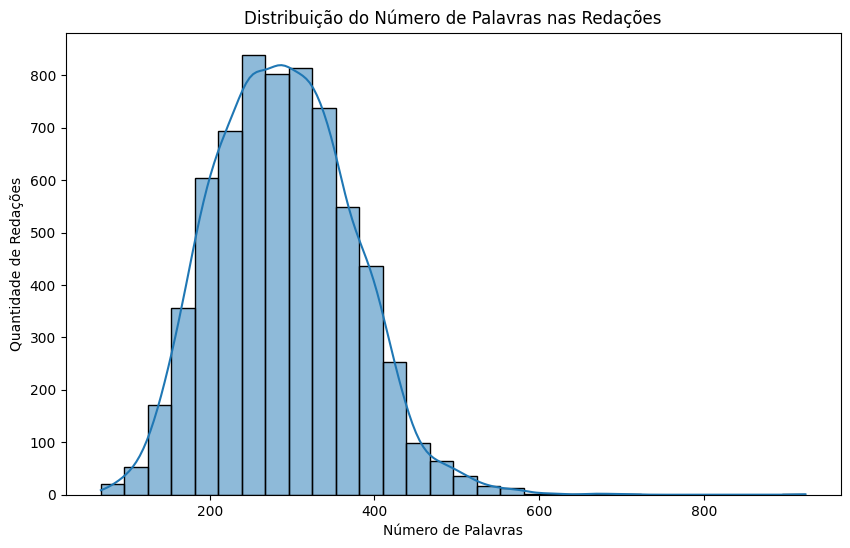

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='word_count', bins=30, kde=True)
plt.title('Distribuição do Número de Palavras nas Redações')
plt.xlabel('Número de Palavras')
plt.ylabel('Quantidade de Redações')
plt.show()


## 3. Extração de Features

### Criação do extrator de features

In [ ]:
features_br = ["cohmetrixBR",
               "lexicalDiversityBR",
               "syntacticComplexityBR",
               "readabilityBR",
               "semanticCohesionBR",
               "textualSimplicityBR"
               ]

feature_extractor = get_extractor(features_br)

nlpbox: download dictionary/biderman-words.v1: 100%|██████████| 22.4k/22.4k [00:00<00:00, 5.05MB/s]
nlpbox: download feature_models/semantic_cohesion.v1: 100%|██████████| 1.42G/1.42G [00:57<00:00, 26.3MB/s]
nlpbox: download dictionary/biderman-concrete-words.v1: 100%|██████████| 26.2k/26.2k [00:00<00:00, 6.55MB/s]


In [ ]:
extraction = feature_extractor.extract("O poeta modernista Oswald de Andrade relata, em \"Erro de Português\", que, sob um dia de chuva, o índio foi vestido pelo português - uma denúncia à aculturação sofrida pelos povos indígenas com a chegada dos europeus ao território brasileiro. Paralelamente, no Brasil atual, há a manutenção de práticas prejudiciais não só aos silvícolas, mas também aos demais povos e comunidades tradicionais, como os pescadores. Com efeito, atuam como desafios para a valorização desses grupos a educação deficiente acerca do tema e a ausência do desenvolvimento sustentável.")
print(json.dumps(extraction.as_dict(), indent=2, ensure_ascii=False))

cohmetrix-BR: download cbow_s50.zip:   0%|          | 0.00/162M [00:00<?, ?B/s]

{
  "adapted_dalechall": 5.09875968992248,
  "adverbs_before_main_verb_ratio": 0.16666666666666666,
  "brunet_indice": 9.066469756208491,
  "clauses_per_sentence": 2.0,
  "cncadc": 1.0,
  "cncadd": 4.0,
  "cncall": 3.0,
  "cncalter": 0.0,
  "cnccaus": 0.0,
  "cnccomp": 1.0,
  "cncconce": 1.0,
  "cncconclu": 0.0,
  "cnccondi": 0.0,
  "cncconfor": 2.0,
  "cncconse": 1.0,
  "cncexpli": 1.0,
  "cncfinal": 1.0,
  "cncinte": 1.0,
  "cnclogic": 3.0,
  "cncneg": 2.0,
  "cncpos": 17.0,
  "cncprop": 0.0,
  "cnctemp": 0.0,
  "coord_conj_ratio": 1.0,
  "coordinate_conjunctions_per_clauses": 0.5,
  "crfao1": 1.0,
  "crfaoa": 1.0,
  "crfcwo1": 0.05499181669394435,
  "crfcwo1d": 0.008837970540098196,
  "crfcwoa": 0.04203755521531774,
  "crfcwoad": 0.019690071857622927,
  "crfno1": 1.0,
  "crfnoa": 1.0,
  "crfso1": 1.0,
  "crfsoa": 1.0,
  "cross_entropy": 0.5307765240131274,
  "despc": 1.0,
  "despc2": 1.0,
  "despl": 3.0,
  "despld": 0.0,
  "dessc": 3.0,
  "dessl": 29.333333333333332,
  "dessld": 8.3

### Extrair features por batch

In [ ]:
batch_size = 1000
num_batches = int(np.ceil(len(df) / batch_size))

batches = np.array_split(df, num_batches)

start_batch = 0

for i in range(start_batch, num_batches):
    batch = batches[i]
    print(f"Processando batch {i + 1}/{num_batches}")

    extraction = [features.as_dict() for features in tqdm(map(feature_extractor.extract, batch["text"]), total=len(batch["text"]))]

    X = extraction
    y = batch.target

    y_df = y.reset_index(drop=True)
    X_df = pd.DataFrame(X).reset_index(drop=True)

    y_df = y_df.rename("target")

    complete_df = pd.concat([X_df, y_df], axis=1)

    complete_df.to_csv(f"batch_{i + 1}.csv", index=False)

Processando batch 1/7


100%|██████████| 938/938 [27:47<00:00,  1.78s/it]


Processando batch 2/7


100%|██████████| 938/938 [34:43<00:00,  2.22s/it]


Processando batch 3/7


100%|██████████| 938/938 [35:58<00:00,  2.30s/it]


Processando batch 4/7


100%|██████████| 938/938 [37:51<00:00,  2.42s/it]


Processando batch 5/7


100%|██████████| 938/938 [39:48<00:00,  2.55s/it]


Processando batch 6/7


100%|██████████| 937/937 [36:11<00:00,  2.32s/it]


Processando batch 7/7


100%|██████████| 937/937 [32:16<00:00,  2.07s/it]


Concatenar batches

In [ ]:
batch_files_pattern = 'batch_*.csv'
batch_files = glob.glob(batch_files_pattern)

batch_dfs = []

for batch_file in batch_files:
    df = pd.read_csv(batch_file)
    batch_dfs.append(df)

concatenated_df = pd.concat(batch_dfs, ignore_index=True)

print(concatenated_df.head())

concatenated_df.to_csv('essay.csv', index=False)

   adapted_dalechall  adverbs_before_main_verb_ratio  brunet_indice  \
0           5.233888                        0.862069      11.438403   
1           5.160748                        0.562500      11.084368   
2           5.202344                        0.413793      11.021616   
3           4.716115                        0.517241      10.877543   
4           4.805250                        0.384615      11.990433   

   clauses_per_sentence  cncadc  cncadd  cncall  cncalter  cnccaus  cnccomp  \
0              2.416667     0.0    13.0     8.0       1.0     17.0     16.0   
1              2.666667     2.0    12.0     7.0       0.0      9.0      8.0   
2              2.636364     3.0     5.0     7.0       2.0     11.0     11.0   
3              2.416667     1.0    12.0     8.0       0.0      9.0     10.0   
4              2.600000     0.0    11.0     8.0       1.0      5.0      4.0   

   ...  wrdprp1p  wrdprp1s  wrdprp2  wrdprp2p  wrdprp2s  wrdprp3p  wrdprp3s  \
0  ...       0.0   

## 4. Salvar conjunto de treino e teste

In [ ]:
# Carregar o dataset CSV
df = pd.read_csv('essay.csv')

# Definir os intervalos de notas (agrupando em 3 classes: ruim, média, boa)
bins = [0, 400, 700, 1000]  # Definir os intervalos das classes
labels = [0, 1, 2]  # 0 = ruim, 1 = média, 2 = boa

# Agrupar as notas em classes maiores
df['nota_classe'] = pd.cut(df['target'], bins=bins, labels=labels, include_lowest=True)

# Separar as features (X) e o novo target (y)
X = df.drop(columns=['target', 'nota_classe'])  # Todas as colunas exceto as notas e a classe
y = df['nota_classe']  # A coluna com as classes das notas

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertendo os dados normalizados de volta para DataFrame para salvar como CSV
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Salvar os dados normalizados e os alvos em CSV
X_train_scaled_df.to_csv('essay_X_train_scaled.csv', index=False)
X_test_scaled_df.to_csv('essay_X_test_scaled.csv', index=False)
y_train.to_csv('essay_y_train.csv', index=False)
y_test.to_csv('essay_y_test.csv', index=False)

print("Os dados normalizados foram salvos com sucesso.")

Os dados normalizados foram salvos com sucesso.


### [Only Test] SMOTE para o desbalanceamento de classes

In [ ]:
# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Confirmar a distribuição de classes após SMOTE
print("Distribuição de classes após SMOTE no conjunto de treino:")
print(y_train_smote.value_counts())

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7bf162057a30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so: cannot open shared object file: No such file or directory


Distribuição de classes após SMOTE no conjunto de treino:
nota_classe
3    2613
2    2613
1    2613
0    2613
4    2613
Name: count, dtype: int64


In [ ]:
# Salvar os dados balanceados e os alvos em CSV
X_train_smote.to_csv('essay_X_train_balanced.csv', index=False)
y_train_smote.to_csv('essay_y_train_balanced.csv', index=False)

print("Os dados balanceados foram salvos com sucesso.")

Os dados balanceados foram salvos com sucesso.


## 5. Treinamento de modelos de classificação

In [ ]:
# Carregar os dados normalizados a partir dos CSVs
X_train_scaled = pd.read_csv('essay_X_train_scaled.csv')
X_test_scaled = pd.read_csv('essay_X_test_scaled.csv')
y_train = pd.read_csv('essay_y_train.csv').squeeze()  # squeeze para transformar em série
y_test = pd.read_csv('essay_y_test.csv').squeeze()

### Hiperparametrização do RandomForestClassifier

In [ ]:
# Definir o grid de parâmetros para Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 300),  # número de árvores entre 50 e 300
    'max_depth': randint(10, 50),  # profundidade das árvores
    'min_samples_split': randint(2, 10),  # número mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 10),  # número mínimo de amostras em cada folha
    'bootstrap': [True, False],  # usar amostragem com ou sem substituição
    'class_weight': [None, 'balanced', 'balanced_subsample']  # incluir class_weight para ajuste
}

# Criar o modelo RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Realizar o RandomizedSearchCV com validação cruzada (cv=3)
rf_random_search = RandomizedSearchCV(rf_classifier,
                                      param_distributions=param_dist_rf,
                                      n_iter=40,
                                      scoring='accuracy',
                                      cv=3,
                                      random_state=42,
                                      n_jobs=-1,
                                      verbose=1)
rf_random_search.fit(X_train_scaled, y_train)

# Melhor modelo
best_rf = rf_random_search.best_estimator_

# Salvar o melhor modelo RandomForestClassifier
joblib.dump(best_rf, 'best_rf_model.joblib')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


['best_rf_model.joblib']

In [ ]:
# Fazer predições no conjunto de teste com o melhor modelo
y_pred_rf = best_rf.predict(X_test_scaled)

# Avaliar a performance do RandomForestClassifier
print("Random Forest Classifier (Melhor Modelo):")
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusão (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier (Melhor Modelo):
              precision    recall  f1-score   support

           0       0.61      0.14      0.22       140
           1       0.63      0.80      0.71       672
           2       0.69      0.60      0.64       501

    accuracy                           0.65      1313
   macro avg       0.64      0.51      0.52      1313
weighted avg       0.65      0.65      0.63      1313

Matriz de confusão (Random Forest):
[[ 19 111  10]
 [ 11 536 125]
 [  1 201 299]]


### Hiperparametrização do LogisticRegression

In [ ]:
# Definir o grid de parâmetros para Regressão Logística
param_dist_lr = {
    'C': uniform(0.1, 10.0),  # Inverso da regularização (quanto menor, mais regularização)
    'penalty': ['l2'],  # Regularização L2
    'solver': ['lbfgs', 'liblinear']  # Solvers disponíveis para a regularização L2
}

# Criar o modelo LogisticRegression
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Realizar o RandomizedSearchCV com validação cruzada (cv=3)
lr_random_search = RandomizedSearchCV(lr_classifier,
                                      param_distributions=param_dist_lr,
                                      n_iter=40,
                                      scoring='accuracy',
                                      cv=3,
                                      random_state=42,
                                      n_jobs=-1,
                                      verbose=1)
lr_random_search.fit(X_train_scaled, y_train)

# Melhor modelo
best_lr = lr_random_search.best_estimator_

# Salvar o melhor modelo LogisticRegression
joblib.dump(best_lr, 'best_lr_model.joblib')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


['best_lr_model.joblib']

In [ ]:
# Fazer predições no conjunto de teste com o melhor modelo
y_pred_lr = best_lr.predict(X_test_scaled)

# Avaliar a performance do LogisticRegression
print("\nLogistic Regression Classifier (Melhor Modelo):")
print(classification_report(y_test, y_pred_lr))
print("Matriz de confusão (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr))

print("Os melhores modelos foram salvos com sucesso.")


Logistic Regression Classifier (Melhor Modelo):
              precision    recall  f1-score   support

           0       0.54      0.20      0.29       140
           1       0.64      0.76      0.69       672
           2       0.68      0.63      0.65       501

    accuracy                           0.65      1313
   macro avg       0.62      0.53      0.54      1313
weighted avg       0.64      0.65      0.63      1313

Matriz de confusão (Logistic Regression):
[[ 28 104   8]
 [ 22 508 142]
 [  2 185 314]]
Os melhores modelos foram salvos com sucesso.
